# Classifiers - busy vs relaxed - no TFv1
Exploring different classifiers with different autoencoders. No contractive autoencoder because it needs TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Undercomplete Autoencoder](#Undercomplete-Autoencoder)  
[Sparse Autoencoder](#Sparse-Autoencoder)  
[Deep Autoencoder](#Deep-Autoencoder)  

classifiers:  
[Simple dense layer](#Simple-dense-layer)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# required for the contractive autoencoder
import tensorflow.keras.backend as K
import json
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.model_selection import RandomizedSearchCV

import warnings

import talos
from talos.utils import lr_normalizer

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']#,
#            keras.metrics.TruePositives(),
#            keras.metrics.FalsePositives(),
#            keras.metrics.TrueNegatives(),
#            keras.metrics.FalseNegatives()]

In [2]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [3]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 before starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [4]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [5]:
def get_busy_vs_relax_timeframes_br_hb(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1)."""
    
    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))

        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)

        try:

            # get extracted features for breathing
            tmpBR_busy = dataextract.extract_from_breathing_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpBR_relax = dataextract_relax.extract_from_breathing_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            #get extracted features for heartbeat
            tmpHB_busy = dataextract.extract_from_heartbeat_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpHB_relax = dataextract.extract_from_heartbeat_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])

            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tasks_y, 1))
            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tmp_tasks_y, 0))

            # put busy frames then relaxed frames under the previous frames
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        except ValueError:
#             print(ident)  # ignore short windows
            continue

        # put busy frames then relaxed frames under the previous frames
        tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 1))
        tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 0))

        breathing = np.vstack((breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        breathing = np.vstack((breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        heartbeat = np.vstack((heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        heartbeat = np.vstack((heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

    return tasks_data, tasks_y, breathing, heartbeat

In [6]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes

            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [7]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [8]:
def clear_session_and_set_seeds():
    # clear session and set seeds again
    K.clear_session()
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [9]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [10]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with standard scaler
phase_all_train = scale(phase_all_train, axis=1)
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with standard scaler
phase_all_valid = scale(phase_all_valid, axis=1)
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [11]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [12]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [13]:
# AE Training params
batch_size = 256
epochs = 2000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [14]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Undercomplete Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [15]:
def undercomplete_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42)(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder = Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [16]:
clear_session_and_set_seeds()
uc_ae, uc_enc = undercomplete_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
uc_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

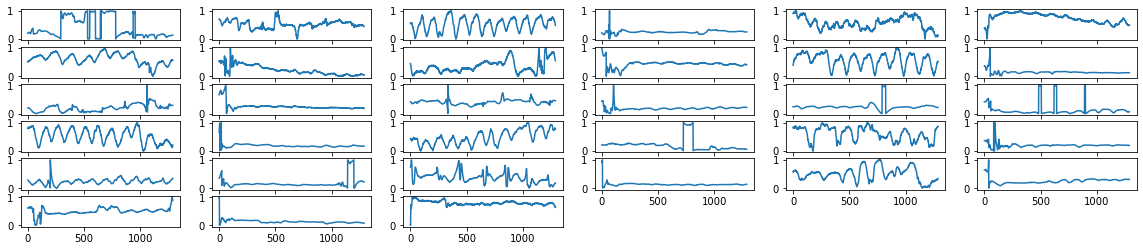

<Figure size 432x288 with 0 Axes>

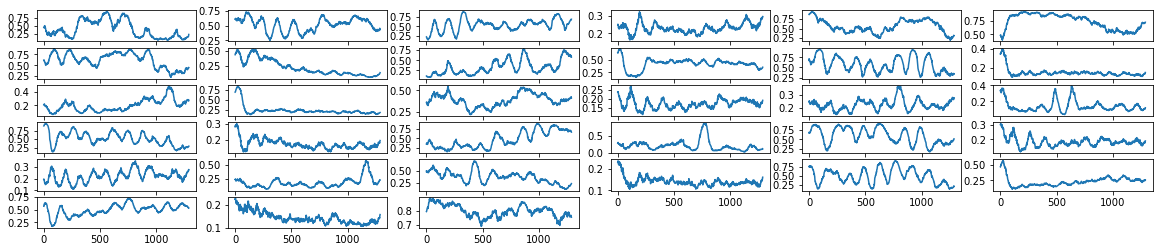

In [17]:
data2 = uc_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

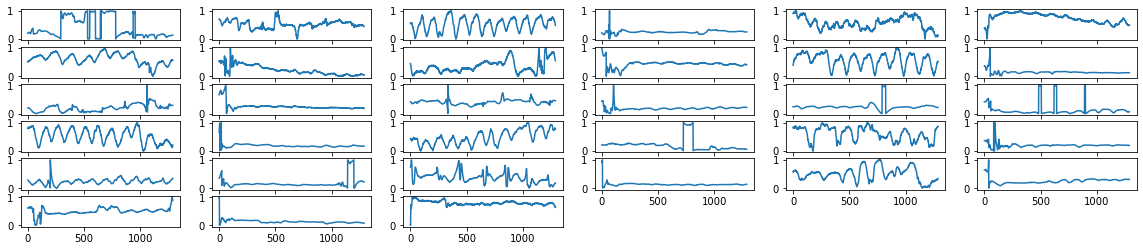

<Figure size 432x288 with 0 Axes>

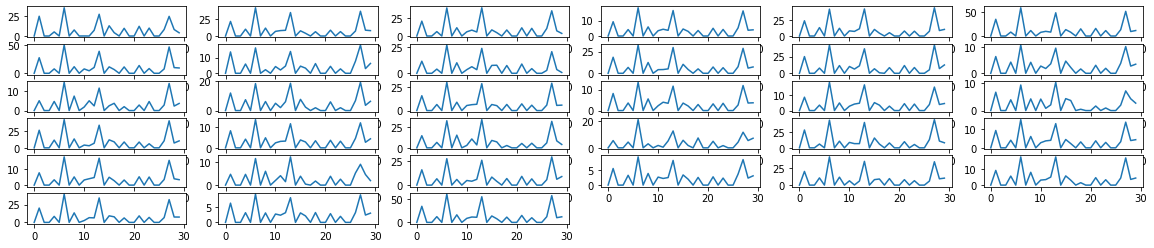

In [18]:
data2 = uc_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [19]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    uc_data = uc_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['undercomplete_encoded'] = uc_data

#### Sparse Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [20]:
def sparse_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42) (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [21]:
clear_session_and_set_seeds()
sp_ae, sp_enc = sparse_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
sp_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

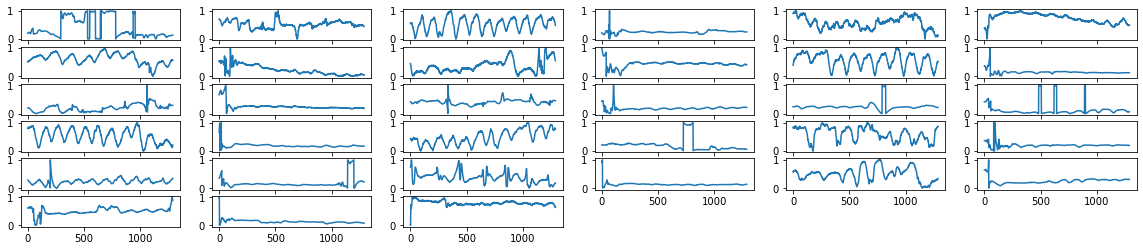

<Figure size 432x288 with 0 Axes>

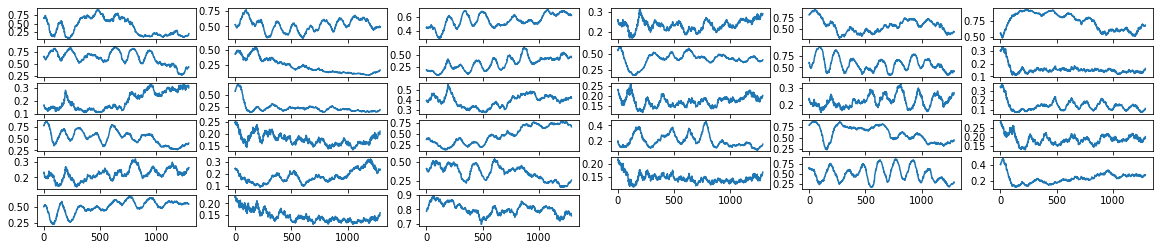

In [22]:
data2 = sp_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

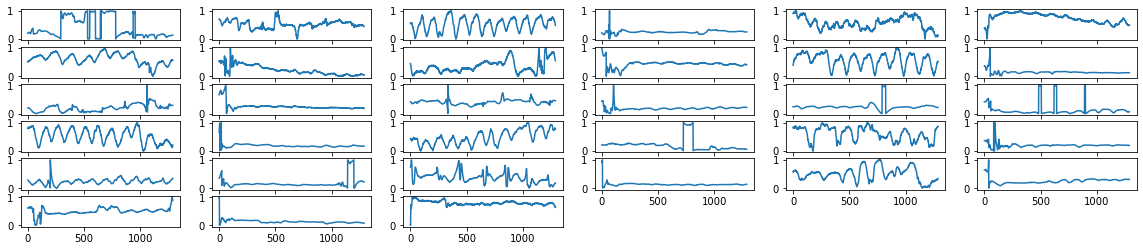

<Figure size 432x288 with 0 Axes>

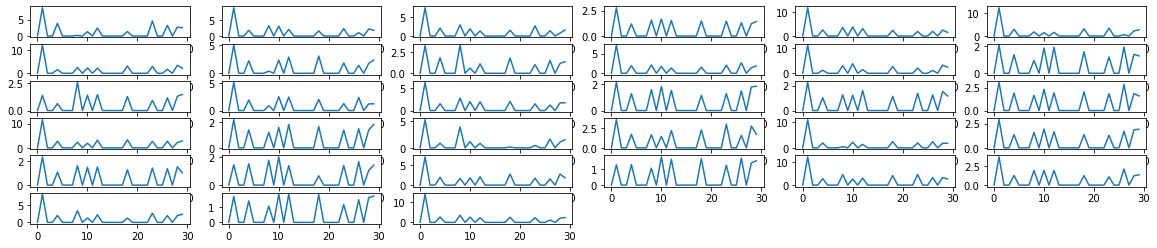

In [23]:
data2 = sp_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [24]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    sp_data = sp_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['sparse_encoded'] = sp_data

#### Deep Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [25]:
def deep_ae(x, enc_layers=[512,128], encoding_dim=64, dec_layers=[128,512], encoded_as_model=False):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    input_data = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.125, name="dropout", autocast=False, seed=42)(input_data)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(input_data, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)

    return autoencoder, encoded

Train autoencoder on data:

In [26]:
clear_session_and_set_seeds()
de_ae, de_enc = deep_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
de_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

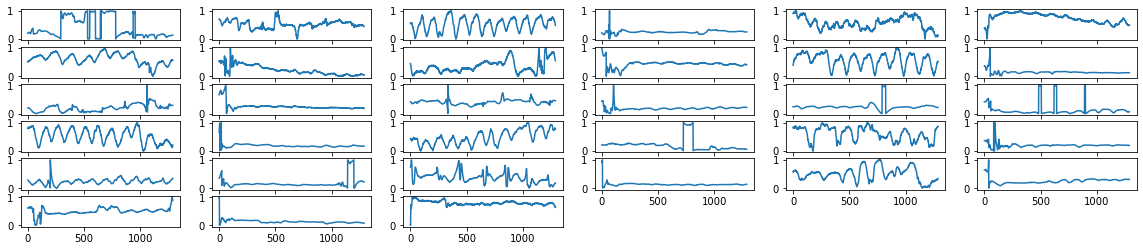

<Figure size 432x288 with 0 Axes>

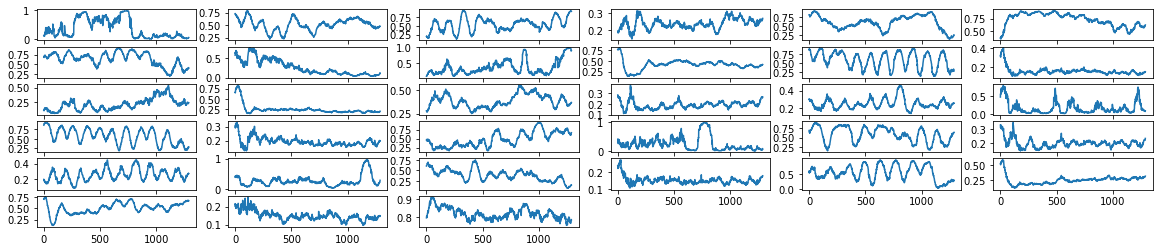

In [27]:
data2 = de_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

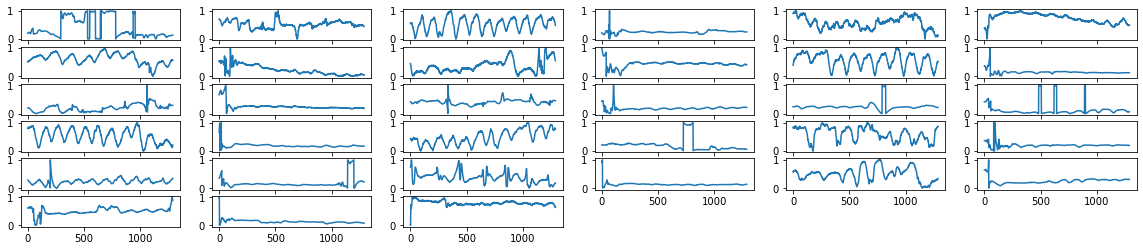

<Figure size 432x288 with 0 Axes>

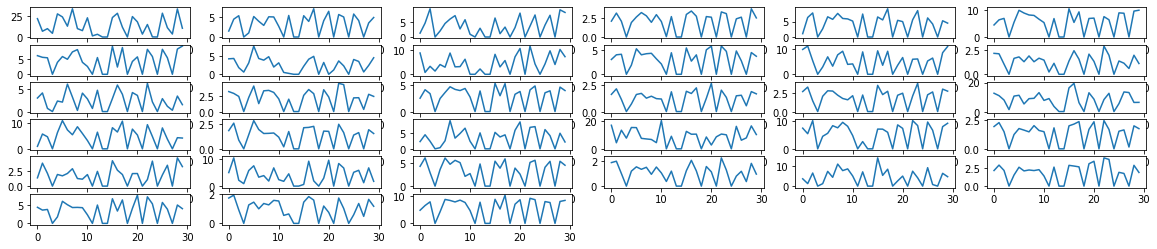

In [28]:
data2 = de_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [29]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    de_data = de_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['deep_encoded'] = de_data

Helper function to get data from the dictionary:

In [30]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    breathing = breathing_shape.copy()
    heartbeat = heartbeat_shape.copy()
    combined = combined_shape.copy()
    undercomplete_encoded = ae_encoded_shape.copy()
    sparse_encoded = ae_encoded_shape.copy()
    deep_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        y = np.vstack((y, data_dict[tmp_id]['y']))
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        breathing = np.vstack((breathing, data_dict[tmp_id]['breathing']))
        heartbeat = np.vstack((heartbeat, data_dict[tmp_id]['heartbeat']))
        combined = np.vstack((combined, data_dict[tmp_id]['combined']))
        undercomplete_encoded = np.vstack((undercomplete_encoded, data_dict[tmp_id]['undercomplete_encoded']))
        sparse_encoded = np.vstack((sparse_encoded, data_dict[tmp_id]['sparse_encoded']))
        deep_encoded = np.vstack((deep_encoded, data_dict[tmp_id]['deep_encoded']))
    
    return y, phase, breathing, heartbeat, combined, undercomplete_encoded, sparse_encoded, deep_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [31]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['breathing'] = []
    accs['heartbeat'] = []
    accs['combined br hb'] = []
    accs['undercomplete'] = []
    accs['sparse'] = []
    accs['deep'] = []
    accs['test id'] = []
    start_time = datetime.now()

    # leave out person out validation
    for i in range(n):
        
        # print current iteration and time elapsed from start
        print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

        ## ----- Data preparation:
        validation_idents = [idents[i]]
        test_idents = [idents[i-1]]
        
        train_idents = []
        for ident in idents:
            if (ident not in test_idents) and (ident not in validation_idents):
                train_idents.append(ident)

        # save test id to see which id yielded which accuracies
        accs['test id'].append(test_idents[0])

        # Load train data
        train_data = get_ident_data_from_dict(train_idents, data_dict)
        y_train = train_data[0]
        
        # Load validation data
        valid_data = get_ident_data_from_dict(validation_idents, data_dict)
        y_valid = valid_data[0]

        # Load test data
        test_data = get_ident_data_from_dict(test_idents, data_dict)
        y_test = test_data[0]
        
        data_names_by_index = ['y', 'phase', 'breathing', 'heartbeat',
                                   'combined br hb', 'undercomplete', 'sparse', 'deep']

        # Loop over all data that will be used for classification and send it to the classifier
        # index 0 is y so we skip it
        for index in range(1, len(test_data)):
            clear_session_and_set_seeds()
            train_x = train_data[index]
            valid_x = valid_data[index]
            test_x = test_data[index]
            
            # Scale data
            if should_scale_data:
                
                # scale phase in a different way than other features
                if (index == 1): 
                    # Scale each row with standard scaler
                    train_x = scale(train_x, axis=1)
                    valid_x = scale(valid_x, axis=1)
                    test_x = scale(test_x, axis=1)
                    # Scale each row with MinMax to range [0,1]
                    train_x = MinMaxScaler().fit_transform(train_x.T).T
                    valid_x = MinMaxScaler().fit_transform(valid_x.T).T
                    test_x = MinMaxScaler().fit_transform(test_x.T).T
                else:
                    # Scale with standard scaler
                    sscaler = StandardScaler()
                    sscaler.fit(train_x)
                    train_x = sscaler.transform(train_x)

                    # Scale with MinMax to range [0,1]
                    mmscaler = MinMaxScaler((0,1))
                    mmscaler.fit(train_x)
                    train_x = mmscaler.transform(train_x)

                    # Scale valid and test with train's scalers
                    valid_x = sscaler.transform(valid_x)
                    valid_x = mmscaler.transform(valid_x)
                    
                    test_x = sscaler.transform(test_x)
                    test_x = mmscaler.transform(test_x)
            
            # Initialize variables
            tmp_acc = []
            data_name = data_names_by_index[index]
            
            for tmp_index in range(num_loops_to_average_over):
                curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                tmp_acc.append(curr_acc)
            
            # Store accuracy
            curr_acc = np.mean(tmp_acc)
            accs[data_name].append(curr_acc)
        

    # Print total time required to run this
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [32]:
params = {
    'dropout': 0.24,
    'optimizer': 'Adam',
    'hidden_size': 64,
    'loss': 'binary_crossentropy',
    'last_activation': 'sigmoid',
    'activation': 'softmax',
    'batch_size': 256,
    'epochs': 100
}

In [33]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    
    # Define the model
    model = Sequential()
    model.add(Dropout(0))
    model.add(Dense(32))
    model.add(Activation('sigmoid'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [34]:
accs = helper_loop(dense_train, idents, n, num_loops_to_average_over=3)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:43.122478
iteration: 3 of 23 ; time elapsed: 0:01:27.534535
iteration: 4 of 23 ; time elapsed: 0:02:10.819421
iteration: 5 of 23 ; time elapsed: 0:02:54.111872
iteration: 6 of 23 ; time elapsed: 0:03:38.390137
iteration: 7 of 23 ; time elapsed: 0:04:22.683835
iteration: 8 of 23 ; time elapsed: 0:05:09.672477
iteration: 9 of 23 ; time elapsed: 0:05:55.293478
iteration: 10 of 23 ; time elapsed: 0:06:41.126849
iteration: 11 of 23 ; time elapsed: 0:07:26.669944
iteration: 12 of 23 ; time elapsed: 0:08:12.044853
iteration: 13 of 23 ; time elapsed: 0:08:57.321533
iteration: 14 of 23 ; time elapsed: 0:09:42.556379
iteration: 15 of 23 ; time elapsed: 0:10:25.527933
iteration: 16 of 23 ; time elapsed: 0:11:08.535044
iteration: 17 of 23 ; time elapsed: 0:11:53.502909
iteration: 18 of 23 ; time elapsed: 0:12:39.914028
iteration: 19 of 23 ; time elapsed: 0:13:25.583556
iteration: 20 of 23 ; time elapsed: 0:14:10.976

In [35]:
accuracies['simple_dense'] = accs

In [36]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.736111,0.458333,0.319444,0.402778,0.611111,0.666667,0.611111,62i9y
1,0.686275,0.666667,0.323529,0.637255,0.480392,0.607843,0.529412,2gu87
2,0.620370,0.879630,0.425926,0.888889,0.435185,0.490741,0.481481,iz2ps
3,0.617647,0.637255,0.392157,0.617647,0.588235,0.372549,0.519608,1mpau
4,0.555556,0.511111,0.388889,0.544444,0.544444,0.377778,0.455556,7dwjy
5,0.677083,0.854167,0.541667,0.843750,0.468750,0.729167,0.635417,7swyk
6,0.614583,0.625000,0.572917,0.625000,0.500000,0.500000,0.520833,94mnx
7,0.444444,0.655556,0.533333,0.666667,0.588889,0.555556,0.611111,bd47a
8,0.555556,0.522222,0.555556,0.677778,0.455556,0.433333,0.466667,c24ur
9,0.577778,0.833333,0.600000,0.833333,0.400000,0.633333,0.633333,ctsax


In [37]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.444444   0.375000   0.319444        0.402778       0.260417  0.372549  0.382353
max     0.736111   0.879630   0.635417        0.888889       0.611111  0.754902  0.635417
mean    0.580148   0.639965   0.496723        0.645125       0.490354  0.558117  0.527101
median  0.555556   0.645833   0.500000        0.656250       0.480392  0.531250  0.510417


#### LSTM-based classifier  
based on the original author's code

In [38]:
params_phase = {
    'kernel_size': 4,
    'filters': 64,
    'strides': 4,
    'pool_size': 4,
    'dropout': 0.09,
    'lstm_output_size': 256,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 128,
    'epochs': 100
}

In [39]:
params_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.09,
    'lstm_output_size': 8,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [40]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change parameters based on which data this gets
    # because phase data has more values so some parameters can be larger (e.g. kernel)
    params = params_br_hb
    if (data_name == 'phase'):
        params = params_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [41]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:01:08.931094
iteration: 3 of 23 ; time elapsed: 0:02:18.019256
iteration: 4 of 23 ; time elapsed: 0:03:26.037029
iteration: 5 of 23 ; time elapsed: 0:04:35.410582
iteration: 6 of 23 ; time elapsed: 0:05:44.204546
iteration: 7 of 23 ; time elapsed: 0:06:53.481485
iteration: 8 of 23 ; time elapsed: 0:08:02.800704
iteration: 9 of 23 ; time elapsed: 0:09:12.115508
iteration: 10 of 23 ; time elapsed: 0:10:19.507973
iteration: 11 of 23 ; time elapsed: 0:11:26.338490
iteration: 12 of 23 ; time elapsed: 0:12:35.632409
iteration: 13 of 23 ; time elapsed: 0:13:46.299811
iteration: 14 of 23 ; time elapsed: 0:14:56.272449
iteration: 15 of 23 ; time elapsed: 0:16:04.147550
iteration: 16 of 23 ; time elapsed: 0:17:13.175817
iteration: 17 of 23 ; time elapsed: 0:18:20.466788
iteration: 18 of 23 ; time elapsed: 0:19:28.575757
iteration: 19 of 23 ; time elapsed: 0:20:36.718091
iteration: 20 of 23 ; time elapsed: 0:21:44.456

In [42]:
accuracies['LSTM'] = accs

In [43]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.791667,0.375000,0.416667,0.458333,0.458333,0.625000,0.583333,62i9y
1,0.529412,0.705882,0.205882,0.588235,0.411765,0.529412,0.529412,2gu87
2,0.861111,0.750000,0.472222,0.555556,0.472222,0.444444,0.472222,iz2ps
3,0.764706,0.529412,0.441176,0.558824,0.617647,0.470588,0.470588,1mpau
4,0.700000,0.666667,0.400000,0.666667,0.366667,0.500000,0.466667,7dwjy
5,0.843750,0.687500,0.687500,0.656250,0.437500,0.625000,0.625000,7swyk
6,0.718750,0.750000,0.500000,0.750000,0.406250,0.562500,0.562500,94mnx
7,0.600000,0.633333,0.566667,0.566667,0.533333,0.633333,0.633333,bd47a
8,0.600000,0.566667,0.400000,0.533333,0.333333,0.433333,0.466667,c24ur
9,0.700000,0.700000,0.500000,0.766667,0.400000,0.666667,0.666667,ctsax


In [44]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.468750   0.361111   0.205882        0.388889       0.187500  0.352941  0.382353
max     0.861111   0.794118   0.687500        0.823529       0.617647  0.666667  0.666667
mean    0.702119   0.613360   0.503815        0.590736       0.447631  0.514441  0.521940
median  0.718750   0.633333   0.500000        0.566667       0.458333  0.500000  0.500000


#### kNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier():
    model = KNeighborsClassifier(p=3, n_neighbors=7, metric='cosine')
    return model

In [46]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = KNN_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [47]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.117743
iteration: 3 of 23 ; time elapsed: 0:00:00.228856
iteration: 4 of 23 ; time elapsed: 0:00:00.379487
iteration: 5 of 23 ; time elapsed: 0:00:00.518119
iteration: 6 of 23 ; time elapsed: 0:00:00.625346
iteration: 7 of 23 ; time elapsed: 0:00:00.730578
iteration: 8 of 23 ; time elapsed: 0:00:00.839639
iteration: 9 of 23 ; time elapsed: 0:00:00.949340
iteration: 10 of 23 ; time elapsed: 0:00:01.058045
iteration: 11 of 23 ; time elapsed: 0:00:01.211635
iteration: 12 of 23 ; time elapsed: 0:00:01.319752
iteration: 13 of 23 ; time elapsed: 0:00:01.424473
iteration: 14 of 23 ; time elapsed: 0:00:01.528195
iteration: 15 of 23 ; time elapsed: 0:00:01.632915
iteration: 16 of 23 ; time elapsed: 0:00:01.736638
iteration: 17 of 23 ; time elapsed: 0:00:01.842356
iteration: 18 of 23 ; time elapsed: 0:00:01.947076
iteration: 19 of 23 ; time elapsed: 0:00:02.052792
iteration: 20 of 23 ; time elapsed: 0:00:02.160

In [48]:
accuracies['kNN'] = accs

In [49]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.458333,0.500000,0.500000,0.541667,0.500000,0.708333,0.375000,62i9y
1,0.705882,0.617647,0.352941,0.617647,0.676471,0.588235,0.676471,2gu87
2,0.611111,0.888889,0.555556,0.861111,0.638889,0.694444,0.583333,iz2ps
3,0.705882,0.676471,0.588235,0.735294,0.588235,0.617647,0.764706,1mpau
4,0.666667,0.566667,0.433333,0.500000,0.633333,0.700000,0.666667,7dwjy
5,0.812500,0.812500,0.531250,0.718750,0.718750,0.687500,0.687500,7swyk
6,0.562500,0.625000,0.375000,0.562500,0.500000,0.718750,0.656250,94mnx
7,0.600000,0.700000,0.533333,0.533333,0.666667,0.633333,0.600000,bd47a
8,0.666667,0.666667,0.466667,0.633333,0.533333,0.566667,0.466667,c24ur
9,0.600000,0.700000,0.533333,0.800000,0.533333,0.733333,0.800000,ctsax


In [50]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.458333   0.441176   0.333333        0.500000       0.400000  0.433333  0.375000
max     0.812500   0.888889   0.625000        0.861111       0.781250  0.781250  0.800000
mean    0.634879   0.647965   0.481749        0.627442       0.591091  0.646405  0.619524
median  0.617647   0.647059   0.466667        0.593750       0.588235  0.676471  0.625000


####  SVC

In [51]:
from sklearn.svm import SVC

def SVC_classifier():
    model = SVC(kernel='rbf', C=1.5)
    return model

In [52]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = SVC_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [53]:
accs = helper_loop(SVC_train, idents, n, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:03.781218
iteration: 3 of 23 ; time elapsed: 0:00:07.530879
iteration: 4 of 23 ; time elapsed: 0:00:11.254841
iteration: 5 of 23 ; time elapsed: 0:00:14.943655
iteration: 6 of 23 ; time elapsed: 0:00:18.688760
iteration: 7 of 23 ; time elapsed: 0:00:22.501799
iteration: 8 of 23 ; time elapsed: 0:00:26.182975
iteration: 9 of 23 ; time elapsed: 0:00:29.852943
iteration: 10 of 23 ; time elapsed: 0:00:33.572608
iteration: 11 of 23 ; time elapsed: 0:00:37.247947
iteration: 12 of 23 ; time elapsed: 0:00:40.906822
iteration: 13 of 23 ; time elapsed: 0:00:44.581334
iteration: 14 of 23 ; time elapsed: 0:00:48.203899
iteration: 15 of 23 ; time elapsed: 0:00:51.908287
iteration: 16 of 23 ; time elapsed: 0:00:55.569940
iteration: 17 of 23 ; time elapsed: 0:00:59.136369
iteration: 18 of 23 ; time elapsed: 0:01:02.784632
iteration: 19 of 23 ; time elapsed: 0:01:06.487834
iteration: 20 of 23 ; time elapsed: 0:01:10.177

In [54]:
accuracies['SVC'] = accs

In [55]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.708333,0.416667,0.625000,0.416667,0.541667,0.625000,0.541667,62i9y
1,0.617647,0.647059,0.411765,0.647059,0.676471,0.529412,0.500000,2gu87
2,0.777778,0.861111,0.388889,0.861111,0.916667,0.638889,0.500000,iz2ps
3,0.617647,0.558824,0.588235,0.647059,0.441176,0.470588,0.500000,1mpau
4,0.600000,0.566667,0.766667,0.566667,0.500000,0.533333,0.500000,7dwjy
5,0.843750,0.781250,0.312500,0.781250,0.625000,0.500000,0.625000,7swyk
6,0.625000,0.593750,0.625000,0.562500,0.687500,0.656250,0.593750,94mnx
7,0.600000,0.633333,0.566667,0.600000,0.466667,0.633333,0.600000,bd47a
8,0.600000,0.666667,0.700000,0.633333,0.633333,0.466667,0.466667,c24ur
9,0.733333,0.800000,0.633333,0.800000,0.666667,0.600000,0.666667,ctsax


In [56]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.527778   0.406250   0.312500        0.416667       0.343750  0.300000  0.400000
max     0.843750   0.861111   0.766667        0.861111       0.916667  0.705882  0.666667
mean    0.666304   0.648378   0.518988        0.642388       0.575742  0.551348  0.517217
median  0.647059   0.656250   0.531250        0.647059       0.562500  0.562500  0.500000


#### Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier():
    model = RandomForestClassifier(n_estimators = 250,
                                     min_samples_split = 10,
                                     min_samples_leaf = 4,
                                     max_features = 'auto',
                                     max_depth = 90,
                                     bootstrap = True)
    return model

In [58]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = random_forest_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [59]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:27.473196
iteration: 3 of 23 ; time elapsed: 0:00:54.532487
iteration: 4 of 23 ; time elapsed: 0:01:21.455691
iteration: 5 of 23 ; time elapsed: 0:01:49.143905
iteration: 6 of 23 ; time elapsed: 0:02:17.975166
iteration: 7 of 23 ; time elapsed: 0:02:46.233137
iteration: 8 of 23 ; time elapsed: 0:03:14.327067
iteration: 9 of 23 ; time elapsed: 0:03:42.353856
iteration: 10 of 23 ; time elapsed: 0:04:10.380380
iteration: 11 of 23 ; time elapsed: 0:04:36.783876
iteration: 12 of 23 ; time elapsed: 0:05:03.115328
iteration: 13 of 23 ; time elapsed: 0:05:29.434683
iteration: 14 of 23 ; time elapsed: 0:05:55.643613
iteration: 15 of 23 ; time elapsed: 0:06:21.758653
iteration: 16 of 23 ; time elapsed: 0:06:48.319008
iteration: 17 of 23 ; time elapsed: 0:07:14.487321
iteration: 18 of 23 ; time elapsed: 0:07:41.081891
iteration: 19 of 23 ; time elapsed: 0:08:08.067564
iteration: 20 of 23 ; time elapsed: 0:08:34.857

In [60]:
accuracies['random_forest'] = accs

In [61]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.758333,0.616667,0.458333,0.491667,0.658333,0.691667,0.791667,62i9y
1,0.594118,0.729412,0.541176,0.694118,0.641176,0.770588,0.623529,2gu87
2,0.738889,0.888889,0.483333,0.888889,0.794444,0.877778,0.811111,iz2ps
3,0.700000,0.658824,0.576471,0.729412,0.500000,0.547059,0.535294,1mpau
4,0.540000,0.633333,0.620000,0.600000,0.420000,0.526667,0.600000,7dwjy
5,0.781250,0.806250,0.418750,0.818750,0.637500,0.800000,0.593750,7swyk
6,0.550000,0.625000,0.556250,0.600000,0.550000,0.556250,0.556250,94mnx
7,0.613333,0.633333,0.533333,0.633333,0.540000,0.600000,0.600000,bd47a
8,0.740000,0.880000,0.573333,0.893333,0.573333,0.573333,0.600000,c24ur
9,0.706667,0.873333,0.693333,0.846667,0.673333,0.706667,0.666667,ctsax


In [62]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.493333   0.418750   0.405882        0.412500       0.420000  0.480000  0.506250
max     0.864706   0.888889   0.693333        0.893333       0.794444  0.877778  0.811111
mean    0.661942   0.695962   0.508428        0.683291       0.577442  0.647935  0.597694
median  0.664706   0.681250   0.516667        0.683333       0.550000  0.637500  0.583333


#### Naive Bayesian

In [63]:
from sklearn.naive_bayes import ComplementNB

def naive_bayesian_classifier():
    model = ComplementNB()
    return model

In [64]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [65]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.088567
iteration: 3 of 23 ; time elapsed: 0:00:00.182518
iteration: 4 of 23 ; time elapsed: 0:00:00.268593
iteration: 5 of 23 ; time elapsed: 0:00:00.366496
iteration: 6 of 23 ; time elapsed: 0:00:00.453832
iteration: 7 of 23 ; time elapsed: 0:00:00.544594
iteration: 8 of 23 ; time elapsed: 0:00:00.635381
iteration: 9 of 23 ; time elapsed: 0:00:00.720740
iteration: 10 of 23 ; time elapsed: 0:00:00.808506
iteration: 11 of 23 ; time elapsed: 0:00:00.898244
iteration: 12 of 23 ; time elapsed: 0:00:00.982966
iteration: 13 of 23 ; time elapsed: 0:00:01.068738
iteration: 14 of 23 ; time elapsed: 0:00:01.157528
iteration: 15 of 23 ; time elapsed: 0:00:01.247359
iteration: 16 of 23 ; time elapsed: 0:00:01.341109
iteration: 17 of 23 ; time elapsed: 0:00:01.436880
iteration: 18 of 23 ; time elapsed: 0:00:01.521656
iteration: 19 of 23 ; time elapsed: 0:00:01.609419
iteration: 20 of 23 ; time elapsed: 0:00:01.692

In [66]:
accuracies['naive_bayesian'] = accs

In [67]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.416667,0.458333,0.291667,0.458333,0.500000,0.666667,0.458333,62i9y
1,0.470588,0.705882,0.382353,0.617647,0.500000,0.529412,0.294118,2gu87
2,0.500000,0.888889,0.444444,0.888889,0.333333,0.527778,0.277778,iz2ps
3,0.588235,0.558824,0.411765,0.617647,0.588235,0.441176,0.500000,1mpau
4,0.533333,0.533333,0.433333,0.500000,0.500000,0.433333,0.266667,7dwjy
5,0.687500,0.843750,0.531250,0.812500,0.531250,0.468750,0.375000,7swyk
6,0.531250,0.562500,0.531250,0.593750,0.468750,0.500000,0.437500,94mnx
7,0.433333,0.633333,0.533333,0.633333,0.466667,0.566667,0.400000,bd47a
8,0.533333,0.533333,0.600000,0.566667,0.433333,0.500000,0.466667,c24ur
9,0.500000,0.900000,0.566667,0.866667,0.533333,0.433333,0.500000,ctsax


In [68]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.323529   0.437500   0.264706        0.437500       0.294118  0.323529  0.266667
max     0.705882   0.900000   0.625000        0.888889       0.588235  0.687500  0.676471
mean    0.492471   0.644855   0.468867        0.640061       0.487209  0.517794  0.466935
median  0.500000   0.625000   0.470588        0.617647       0.500000  0.500000  0.466667


#### XGBoost

In [69]:
from xgboost import XGBClassifier

def XGBoost_classifier():
    model = XGBClassifier(n_estimators = 83)
    return model

In [70]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = XGBoost_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [71]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:12.045701
iteration: 3 of 23 ; time elapsed: 0:00:23.599500
iteration: 4 of 23 ; time elapsed: 0:00:35.536271
iteration: 5 of 23 ; time elapsed: 0:00:47.244878
iteration: 6 of 23 ; time elapsed: 0:00:58.917238
iteration: 7 of 23 ; time elapsed: 0:01:10.943434
iteration: 8 of 23 ; time elapsed: 0:01:22.599445
iteration: 9 of 23 ; time elapsed: 0:01:34.385109
iteration: 10 of 23 ; time elapsed: 0:01:46.195259
iteration: 11 of 23 ; time elapsed: 0:01:57.420885
iteration: 12 of 23 ; time elapsed: 0:02:08.764199
iteration: 13 of 23 ; time elapsed: 0:02:20.163709
iteration: 14 of 23 ; time elapsed: 0:02:32.098040
iteration: 15 of 23 ; time elapsed: 0:02:44.019856
iteration: 16 of 23 ; time elapsed: 0:02:55.581366
iteration: 17 of 23 ; time elapsed: 0:03:07.210943
iteration: 18 of 23 ; time elapsed: 0:03:18.645812
iteration: 19 of 23 ; time elapsed: 0:03:30.029897
iteration: 20 of 23 ; time elapsed: 0:03:41.728

In [72]:
accuracies['XGBoost'] = accs

In [73]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.625000,0.625000,0.500000,0.583333,0.666667,0.708333,0.583333,62i9y
1,0.617647,0.794118,0.500000,0.705882,0.647059,0.588235,0.676471,2gu87
2,0.666667,0.861111,0.527778,0.861111,0.611111,0.777778,0.694444,iz2ps
3,0.735294,0.617647,0.588235,0.794118,0.352941,0.676471,0.588235,1mpau
4,0.600000,0.633333,0.566667,0.633333,0.433333,0.533333,0.566667,7dwjy
5,0.718750,0.750000,0.375000,0.750000,0.750000,0.843750,0.656250,7swyk
6,0.625000,0.656250,0.437500,0.593750,0.531250,0.593750,0.562500,94mnx
7,0.633333,0.566667,0.500000,0.433333,0.433333,0.566667,0.566667,bd47a
8,0.566667,0.900000,0.533333,0.866667,0.566667,0.600000,0.666667,c24ur
9,0.700000,0.766667,0.666667,0.800000,0.533333,0.600000,0.533333,ctsax


In [74]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.466667   0.500000   0.343750        0.343750       0.352941  0.466667  0.406250
max     0.735294   0.900000   0.687500        0.866667       0.750000  0.843750  0.694444
mean    0.625753   0.685035   0.501948        0.685170       0.548664  0.632243  0.566615
median  0.625000   0.676471   0.500000        0.700000       0.533333  0.600000  0.566667


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [75]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.444444   0.375000   0.319444        0.402778       0.260417  0.372549  0.382353
max     0.736111   0.879630   0.635417        0.888889       0.611111  0.754902  0.635417
mean    0.580148   0.639965   0.496723        0.645125       0.490354  0.558117  0.527101
median  0.555556   0.645833   0.500000        0.656250       0.480392  0.531250  0.510417


----------- LSTM: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.468750   0.361111   0.205882        0.388889       0.187500  0.352941  0.382353
max     0.861111   0.794118   0.687500        0.823529       0.617647  0.666667  0.666667
mean    0.702119   0.613360   0.503815        0.590736       0.447631  0.514441  0.521940
median  0.718750   0.633333   0.500000        0.566667       0.458333  0.500000  0.500000


----------- kNN: -----------

Print all accuracies in table form:

In [76]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   0.736111   0.458333   0.319444        0.402778       0.611111  0.666667  0.611111   62i9y
1   0.686275   0.666667   0.323529        0.637255       0.480392  0.607843  0.529412   2gu87
2   0.620370   0.879630   0.425926        0.888889       0.435185  0.490741  0.481481   iz2ps
3   0.617647   0.637255   0.392157        0.617647       0.588235  0.372549  0.519608   1mpau
4   0.555556   0.511111   0.388889        0.544444       0.544444  0.377778  0.455556   7dwjy
5   0.677083   0.854167   0.541667        0.843750       0.468750  0.729167  0.635417   7swyk
6   0.614583   0.625000   0.572917        0.625000       0.500000  0.500000  0.520833   94mnx
7   0.444444   0.655556   0.533333        0.666667       0.588889  0.555556  0.611111   bd47a
8   0.555556   0.522222   0.555556        0.677778       0.455556  0.433333  0.466667   c24ur
9   0.577778   0.833333   0.600000        0.83